# Phase 1 Milestone 2

## I. Perkenalan

Nama : Reido Vidaya Mahardika  
Batch : RMT - 040  
Objective : Membuat model machine learning untuk prediksi harga taxi menggunakan Random Forest Regressor.

## II. Import Libraries

In [1]:
!pip install feature-engine

In [2]:
!pip install phik

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from phik import phik_matrix
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

## III. Data Loading

In [4]:
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id_akun = "hckreido"
client = bigquery.Client(project=project_id_akun)

Authenticated


In [5]:
#Get data from Bigquery
taxi = client.query('''

SELECT vendor_id, dropoff_datetime, rate_code, passenger_count, trip_distance, payment_type, fare_amount, extra, tip_amount, tolls_amount, imp_surcharge, total_amount
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
ORDER BY dropoff_datetime DESC
LIMIT 10000;

''').to_dataframe()

taxi

,vendor_id,dropoff_datetime,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2017-01-01 23:38:44+00:00,1,1,0.76,1,5.0,0.5,0.00,0.0,0.3,6.30
1,2,2017-01-01 23:34:56+00:00,1,1,0.21,2,3.5,0.5,0.00,0.0,0.3,4.80
2,2,2017-01-01 23:31:54+00:00,1,5,5.46,2,17.5,0.5,0.00,0.0,0.3,18.80
3,2,2017-01-01 23:31:09+00:00,1,2,2.92,2,15.0,0.5,0.00,0.0,0.3,16.30
4,2,2017-01-01 23:30:08+00:00,1,1,1.71,1,7.0,0.5,1.24,0.0,0.3,9.54
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2016-12-31 23:28:14+00:00,1,1,1.30,1,8.0,0.5,2.75,0.0,0.3,12.05
9996,2,2016-12-31 23:28:14+00:00,1,2,0.84,2,4.5,0.5,0.00,0.0,0.3,5.80
9997,2,2016-12-31 23:28:13+00:00,1,1,1.11,1,6.5,0.5,1.56,0.0,0.3,9.36
9998,2,2016-12-31 23:28:13+00:00,1,1,0.41,1,4.0,0.5,1.06,0.0,0.3,6.36


In [6]:
# Duplicate Data
df = taxi.copy()

# Menampilkan 5 data teratas
df.head()

,vendor_id,dropoff_datetime,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,imp_surcharge,total_amount
0,2,2017-01-01 23:38:44+00:00,1,1,0.76,1,5.0,0.5,0.00,0.0,0.3,6.30
1,2,2017-01-01 23:34:56+00:00,1,1,0.21,2,3.5,0.5,0.00,0.0,0.3,4.80
2,2,2017-01-01 23:31:54+00:00,1,5,5.46,2,17.5,0.5,0.00,0.0,0.3,18.80
3,2,2017-01-01 23:31:09+00:00,1,2,2.92,2,15.0,0.5,0.00,0.0,0.3,16.30
4,2,2017-01-01 23:30:08+00:00,1,1,1.71,1,7.0,0.5,1.24,0.0,0.3,9.54


In [7]:
# Menampilkan 5 data terbawah
df.tail()

,vendor_id,dropoff_datetime,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,imp_surcharge,total_amount
9995,1,2016-12-31 23:28:14+00:00,1,1,1.30,1,8.0,0.5,2.75,0.0,0.3,12.05
9996,2,2016-12-31 23:28:14+00:00,1,2,0.84,2,4.5,0.5,0.00,0.0,0.3,5.80
9997,2,2016-12-31 23:28:13+00:00,1,1,1.11,1,6.5,0.5,1.56,0.0,0.3,9.36
9998,2,2016-12-31 23:28:13+00:00,1,1,0.41,1,4.0,0.5,1.06,0.0,0.3,6.36
9999,1,2016-12-31 23:28:12+00:00,1,1,9.30,1,31.0,0.5,0.00,0.0,0.3,32.30


In [8]:
# Summary df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   vendor_id         10000 non-null  object             
 1   dropoff_datetime  10000 non-null  datetime64[us, UTC]
 2   rate_code         10000 non-null  Int64              
 3   passenger_count   10000 non-null  Int64              
 4   trip_distance     10000 non-null  float64            
 5   payment_type      10000 non-null  object             
 6   fare_amount       10000 non-null  float64            
 7   extra             10000 non-null  float64            
 8   tip_amount        10000 non-null  float64            
 9   tolls_amount      10000 non-null  float64            
 10  imp_surcharge     10000 non-null  float64            
 11  total_amount      10000 non-null  float64            
dtypes: Int64(2), datetime64[us, UTC](1), float64(7), object(2)
me

DataFrame memiliki 10000 baris dan 12 kolom dengan type data integer sebanyak 2 kolom, datetime 1 kolom float 7 kolom danobject 2 kolom.

rate_code dan payment type merupakan categorical yang sudah diencode akan diubah ke object dahulu untuk memudahkan pembacaan.

In [9]:
df.describe()

,rate_code,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,imp_surcharge,total_amount
count,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.045,1.7423,3.622446,13.977351,0.474500,1.487067,0.246447,0.299490,16.985900
std,0.343783,1.304171,4.328686,12.435617,0.119588,2.529010,1.881958,0.017227,14.378041
min,1.0,0.0,0.000000,-5.000000,-0.500000,0.000000,0.000000,-0.300000,-6.300000
25%,1.0,1.0,1.090000,6.500000,0.500000,0.000000,0.000000,0.300000,8.300000
50%,1.0,1.0,2.060000,10.000000,0.500000,0.000000,0.000000,0.300000,12.300000
75%,1.0,2.0,4.410000,17.000000,0.500000,2.050000,0.000000,0.300000,20.300000
max,5.0,6.0,85.890000,396.000000,4.500000,33.000000,100.000000,0.300000,397.300000


In [10]:
# Ubah rate_code

rate_code_mapping = {'1': 'Standard rate',
                      '2': 'JFK',
                      '3': 'Newark',
                      '4': 'Nassau or Westchester',
                      '5': 'Negotiated fare',
                      '6': 'Group ride'}

df['rate_code'] = df['rate_code'].astype(str)
df['rate_code'] = df['rate_code'].replace(rate_code_mapping)
df['rate_code'].unique()

array(['Standard rate', 'JFK', 'Nassau or Westchester', 'Negotiated fare',
       'Newark'], dtype=object)

In [11]:
df["rate_code"].dtype

dtype('O')

In [12]:
# Ubah payment_type

payment_type_mapping = {'1': 'Credit Card',
                        '2': 'Cash',
                        '3': 'No Charge',
                        '4': 'Dispute'}

df['payment_type'] = df['payment_type'].astype(str)
df['payment_type'] = df['payment_type'].replace(payment_type_mapping)
df['payment_type'].unique()

array(['Credit Card', 'Cash', 'No Charge', 'Dispute'], dtype=object)

In [13]:
# Cek Missing value
df.isnull().sum()

,0
vendor_id,0
dropoff_datetime,0
rate_code,0
passenger_count,0
trip_distance,0
payment_type,0
fare_amount,0
extra,0
tip_amount,0
tolls_amount,0


DataFrame ini tidak memiliki missing value

In [14]:
#ubah ke string untuk di encode
df['passenger_count'] = df['passenger_count'].astype(str)

In [15]:
# Save Dataset
df.to_csv('taxi.csv', index=False)

## IV. Exploratory Data Analysis

1. Ada berapa jenis pembayaran yang bisa dilakukan dan pembayaran apa yang paling banyak dilakukan?

In [16]:
# Hitung Jumlah per type
payment_type_count = df['payment_type'].value_counts()
payment_type_count

,count
payment_type,
Credit Card,5134
Cash,4745
No Charge,90
Dispute,31


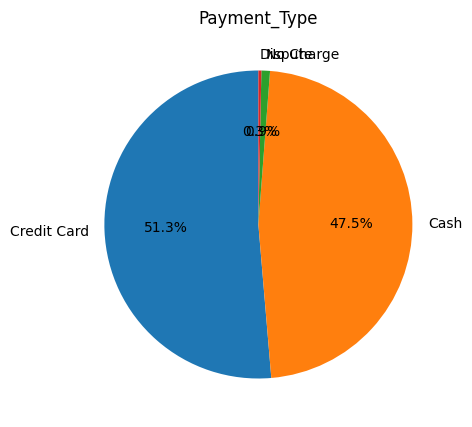

In [17]:
# Membuat pie plot
plt.figure(figsize=(5, 5))
payment_type_count.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Payment_Type')
plt.ylabel('')
plt.show()

Terdapat 4 jenis pembayaran dan sebanyak 51.3% pembayaran dilakukan menggunakan credit card.

2. berapa jumlah penumpang per trip?

In [18]:
passenger_count = df['passenger_count'].value_counts()
passenger_count

,count
passenger_count,
1,6545
2,1712
3,589
5,529
4,351
6,273
0,1


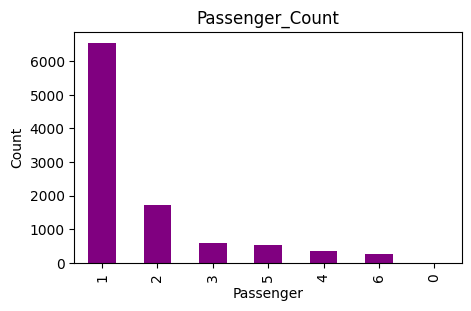

In [19]:
plt.figure(figsize=(5, 3))
passenger_count.plot(kind='bar', color='purple')
plt.xlabel('Passenger')
plt.ylabel('Count')
plt.title('Passenger_Count')
plt.show()

Didapatkan taxi paling sering mendapatkan jumlah penumpang 1 orang per tripnya.

## V. Feature Engineering

Bagian ini berisikan data preparation process sebelum dilakukannya model training.

In [20]:
# Check df before FE
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   vendor_id         10000 non-null  object             
 1   dropoff_datetime  10000 non-null  datetime64[us, UTC]
 2   rate_code         10000 non-null  object             
 3   passenger_count   10000 non-null  object             
 4   trip_distance     10000 non-null  float64            
 5   payment_type      10000 non-null  object             
 6   fare_amount       10000 non-null  float64            
 7   extra             10000 non-null  float64            
 8   tip_amount        10000 non-null  float64            
 9   tolls_amount      10000 non-null  float64            
 10  imp_surcharge     10000 non-null  float64            
 11  total_amount      10000 non-null  float64            
dtypes: datetime64[us, UTC](1), float64(7), object(4)
memory usage

Saya akan melakukan drop pada vendor_id dan dropoff_datetime dikarenakan tidak dibutuhkan.

In [21]:
# Drop Column
df = df.drop(['vendor_id', 'dropoff_datetime'], axis=1)

In [22]:
# Check Duplicate
df.duplicated().sum()

1877

Terdapat 1877 data duplikat dan akan di drop dikarenakan data duplikat tidak diperlukan untuk pembuatan machine learning.

In [23]:
df = df.drop_duplicates()
df.duplicated().sum()

0

Data Duplikat berhasil di drop

### Cardinality

Handle cardinality dikarenakan semakin low cardinality model akan semakin baik.

In [24]:
# Cek banyaknya unique data
rate_code_count = df['rate_code'].value_counts()
rate_code_count

,count
rate_code,
Standard rate,7875
JFK,178
Negotiated fare,52
Nassau or Westchester,14
Newark,4


Berdasarkan distribusi data diatas selain Standard rate akan diubah menjadi other untuk mengurangi cardinality.

In [25]:
#Replace to other
df['rate_code'] = df['rate_code'].replace(['JFK', 'Newark', 'Nassau or Westchester', 'Negotiated fare'], 'Other')
rate_code_count = df['rate_code'].value_counts()
rate_code_count

,count
rate_code,
Standard rate,7875
Other,248


Handling Cardinality pada kolom rate_code berhasi dilakukan. Selanjutnya akan dilakukan handling cardinality pada kolom payment_type.

In [26]:
# Cek banyaknya unique data
payment_type_count = df['payment_type'].value_counts()
payment_type_count

,count
payment_type,
Credit Card,4604
Cash,3410
No Charge,78
Dispute,31


In [27]:
# Imputasi dengan modus
mode_payment = df['payment_type'].mode()[0]
df['payment_type'] = df['payment_type'].replace(['No Charge', 'Dispute'], mode_payment)

payment_type_count = df['payment_type'].value_counts()
payment_type_count

,count
payment_type,
Credit Card,4713
Cash,3410


### Split X and y

In [28]:
# Split X dan y
X = df.drop('total_amount', axis=1)
y = df['total_amount']
df.head()

,rate_code,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,imp_surcharge,total_amount
0,Standard rate,1,0.76,Credit Card,5.0,0.5,0.00,0.0,0.3,6.30
1,Standard rate,1,0.21,Cash,3.5,0.5,0.00,0.0,0.3,4.80
2,Standard rate,5,5.46,Cash,17.5,0.5,0.00,0.0,0.3,18.80
3,Standard rate,2,2.92,Cash,15.0,0.5,0.00,0.0,0.3,16.30
4,Standard rate,1,1.71,Credit Card,7.0,0.5,1.24,0.0,0.3,9.54


kolom target adalah total_amount dikarenakan saya ingin memprediksi harga yang akan di bayar oleh penumpang taxi.

In [29]:
# Split Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=26)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (6092, 9)
Test Size  :  (2031, 9)


Data train memiliki 6092 baris dan 9 kolom pada data test memiliki 1873 baris dan 9 kolom.

### Split Numerical Columns and Categorical Columns

In [30]:
#Split num and cat
num_columns = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'imp_surcharge']
cat_columns = ['passenger_count','rate_code', 'payment_type']

print('Num Columns : ', num_columns)
print('Cat Columns : ', cat_columns)

Num Columns :  ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'imp_surcharge']
Cat Columns :  ['passenger_count', 'rate_code', 'payment_type']


### Handling Invalid Values

In [31]:
# Mengecek jumlah nilai negatif

num_columns = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'imp_surcharge']

negative_X_train = (X_train[num_columns] < 0).sum().sum()
negative_X_test = (X_test[num_columns]  < 0).sum().sum()
negative_y_train = (y_train < 0).sum()
negative_y_test = (y_test < 0).sum()

print(f"Jumlah nilai negatif di X_train: {negative_X_train}")
print(f"Jumlah nilai negatif di X_test: {negative_X_test}")
print(f"Jumlah nilai negatif di y_train: {negative_y_train}")
print(f"Jumlah nilai negatif di y_test: {negative_y_test}")


Jumlah nilai negatif di X_train: 12
Jumlah nilai negatif di X_test: 12
Jumlah nilai negatif di y_train: 4
Jumlah nilai negatif di y_test: 4


In [32]:
# Mengecek nilai negatif
negative_X_train = (X_train[num_columns] < 0).any(axis=1)
negative_X_test = (X_test[num_columns] < 0).any(axis=1)

# Mendapatkan indeks baris yang akan dihapus
index_to_drop_train = X_train[negative_X_train].index
index_to_drop_test = X_test[negative_X_test].index

# Menghapus baris dari X_train dan X_test
X_train = X_train.drop(index_to_drop_train)
X_test = X_test.drop(index_to_drop_test)

# Menghapus baris dari berdasarkan indeks X_train dan X_test
y_train = y_train.drop(index_to_drop_train)
y_test = y_test.drop(index_to_drop_test)

# Cek nilai negatif setelah didrop
negative_X_train = (X_train[num_columns] < 0).sum().sum()
negative_X_test = (X_test[num_columns] < 0).sum().sum()
negative_y_train = (y_train < 0).sum()
negative_y_test = (y_test < 0).sum()

print(f"Jumlah nilai negatif di X_train: {negative_X_train}")
print(f"Jumlah nilai negatif di X_test: {negative_X_test}")
print(f"Jumlah nilai negatif di y_train: {negative_y_train}")
print(f"Jumlah nilai negatif di y_test: {negative_y_test}")

Jumlah nilai negatif di X_train: 0
Jumlah nilai negatif di X_test: 0
Jumlah nilai negatif di y_train: 0
Jumlah nilai negatif di y_test: 0


Invalid value berhasil di handle

### Handling Missing Value

In [33]:
X_train.isnull().sum().sum()

0

In [34]:
X_test.isnull().sum().sum()

0

In [35]:
y_train.isnull().sum().sum()

0

In [36]:
y_test.isnull().sum().sum()

0

Tidak terdapat missing value

In [37]:
passenger_count = X_train['passenger_count'].value_counts()
passenger_count

,count
passenger_count,
1,3649
2,1141
3,438
5,404
4,250
6,205
0,1


Seharusnya tidak ada penumpang yang berjumlah 0 maka akan didrop.

In [38]:
# Mendapatkan indeks baris di mana passenger_count 0
index_to_drop_train = X_train[X_train['passenger_count'] == '0'].index

# Menghapus baris dari X_train
X_train = X_train.drop(index_to_drop_train)

# Menghapus baris dari y_train berdasarkan indeks X_train
y_train = y_train.drop(index_to_drop_train)

# Cek setelah di drop
passenger_count = X_train['passenger_count'].value_counts()
print(passenger_count)

passenger_count
1    3649
2    1141
3     438
5     404
4     250
6     205
Name: count, dtype: int64


### Handling Outlier

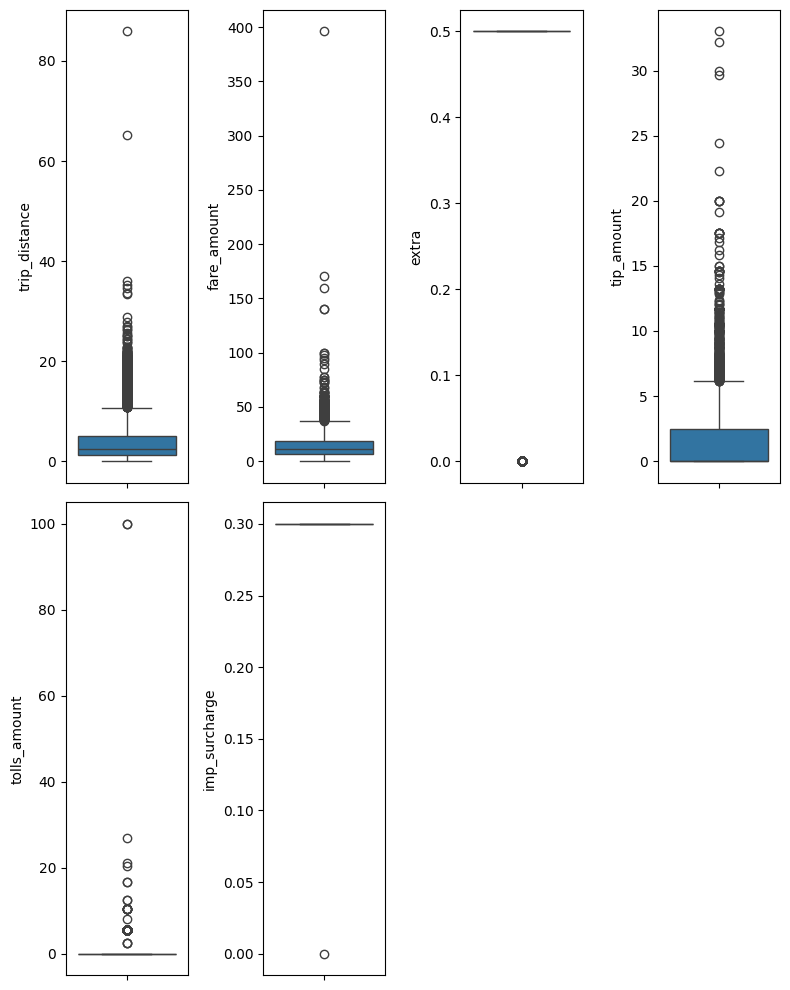

In [39]:
#Define Num Columns
num_columns = ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'imp_surcharge']

num = len(num_columns)
num_rows = 2
num_cols = 4

plt.figure(figsize=(8, 10))

# Membuat boxplot untuk setiap num_columns
for i, feature in enumerate(num_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(data=X_train, y=feature)

plt.tight_layout()
plt.show()

Data memiliki beberapa outliers dan dikarenakan data berharga dan tidak inign di drop maka akan dihandle menggunakan winsorizer. untuk kolom extra, tolls_amount dan imp_surcharge tidak di ikutkan karena variasi data terlalu rendah.

In [40]:
inc_columns = ['trip_distance', 'fare_amount', 'tip_amount']

# create Winsorizer transformer to replace outliers with the maximum and minimum values of the variable
winsorizer = Winsorizer(capping_method='quantiles', tail='both', fold=0.05, variables=inc_columns)

# fit transformer to the dataset
winsorizer.fit(X_train)

# transform the dataset
X_train_winsorized = winsorizer.transform(X_train)

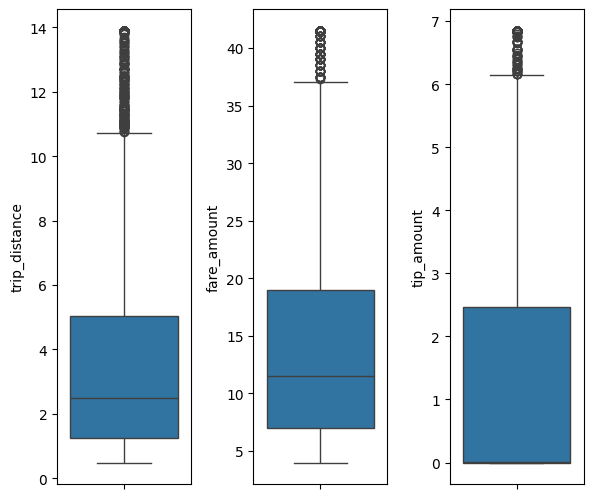

In [41]:
inc_columns = ['trip_distance', 'fare_amount', 'tip_amount']

num_inc = len(inc_columns)
num_rows = 2
num_cols = 4

plt.figure(figsize=(8, 10))

# Membuat boxplot untuk setiap inc_columns
for i, feature in enumerate(inc_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(data=X_train_winsorized, y=feature)

plt.tight_layout()
plt.show()

In [42]:
# Split Train-Set and Test-Set

X_train_num = X_train_winsorized[num_columns]
X_test_num = X_test[num_columns]

X_train_cat = X_train[cat_columns]
X_test_cat = X_test[cat_columns]

### Feature Selection

#### Check Assumption

interval columns not set, guessing: ['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 'imp_surcharge', 'total_amount']


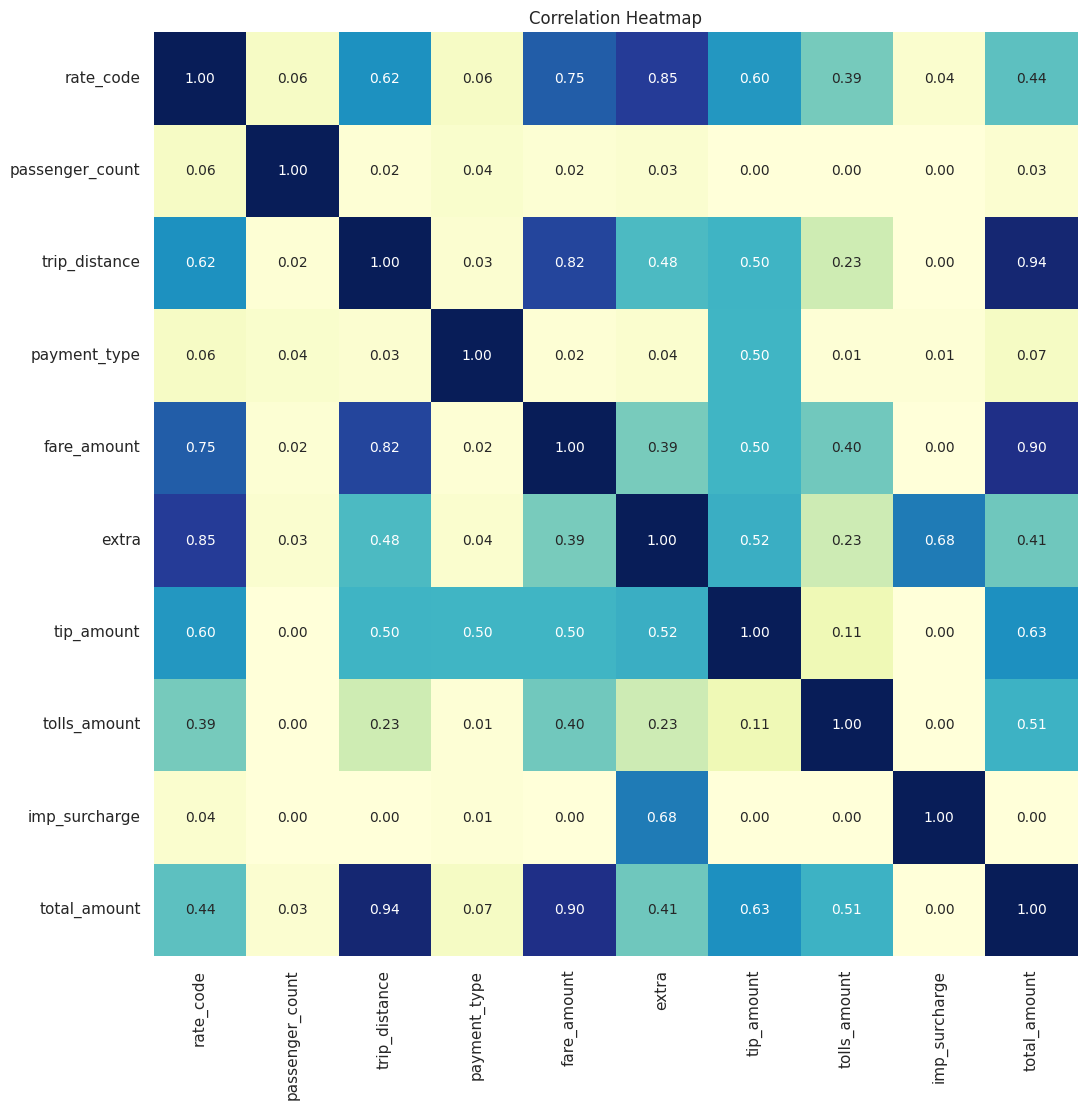

In [43]:
# Check Correlation
corr = df.phik_matrix()

# Create heatmap
sns.set(font_scale=1)
plt.figure(figsize=(12, 12))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt='.2f', annot_kws={'size': 10}, square=True, cbar=False)
plt.title('Correlation Heatmap')
plt.show()

Berdasarkan heatmap korelasi diatas hampir semua feature memiliki korelasi. Namun saat ini saya akan memilih variable yang di input sebelum pelanggan menaiki taxi.

In [44]:
num_columns_selected = ['trip_distance']
cat_columns_selected = ['rate_code','payment_type', 'passenger_count']

# Memilih fitur terseleksi dari DataFrame train_num
X_train_num_selected = X_train_winsorized[num_columns_selected]
X_test_num_selected = X_test_num[num_columns_selected]

# Memilih fitur terseleksi dari DataFrame train_cat
X_train_cat_selected = X_train_cat[cat_columns_selected]
X_test_cat_selected = X_test_cat[cat_columns_selected]

# Menggabungkan fitur menjadi df_train
X_train_selected = pd.concat([X_train_num_selected, X_train_cat_selected], axis=1)
X_test_selected = pd.concat([X_test_num_selected, X_test_cat_selected], axis=1)

print('Train Size : ', X_train_selected.shape)
print('Test Size  : ', X_test_selected.shape)

Train Size :  (6087, 4)
Test Size  :  (2027, 4)


### Feature Scaling and Encoding

Scaling data akan dilakukan dengan Robust scaler dikarenakan data masih memiliki outlier dan untuk encoding menggunakan one hot encoding dikarenakan data categorical discrete

In [45]:
#Scaling and encoding using ColumnTransformer
scaler = RobustScaler()
ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)

preprocess = ColumnTransformer(
    transformers = [
        ('num',scaler,num_columns_selected),
        ('cat',ohe,cat_columns_selected)],
    remainder='passthrough' # untuk categorical yg sdh di encode
)

## VI. Model Definition

In [46]:
pipelinreg = make_pipeline(preprocess, LinearRegression())
pipeknn = make_pipeline(preprocess, KNeighborsRegressor())
pipesvr = make_pipeline(preprocess, SVR())
pipedt = make_pipeline(preprocess, DecisionTreeRegressor())
piperf = make_pipeline(preprocess, RandomForestRegressor())

In [47]:
# Boosting use adaboost
pipeadaboost = make_pipeline(preprocess, AdaBoostRegressor(n_estimators=50, random_state=26))


## VII. Model Training

### Fit to Train

In [48]:
pipelinreg.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('linearregression', LinearRegression())])

In [49]:
pipeknn.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [50]:
pipesvr.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('svr', SVR())])

In [51]:
pipedt.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [52]:
piperf.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [53]:
pipeadaboost.fit(X_train_selected, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['trip_distance']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['rate_code', 'payment_type',
                                                   'passenger_count'])])),
                ('adaboostregressor', AdaBoostRegressor(random_state=26))])

### Check coefficients and intercept

In [54]:
# Mengambil model LinearRegression dari pipeline
model_linreg = pipelinreg.named_steps['linearregression']
intercept = model_linreg.intercept_
coefficients = model_linreg.coef_

# Mengakses OneHotEncoder
ohe = pipelinreg.named_steps['columntransformer'].transformers_[1][1]

# Mendapatkan nama kolom hasil encoding
cat_columns_encoded = ohe.get_feature_names_out(cat_columns_selected)

# Gabungkan semua nama kolom
all_columns = num_columns_selected + list(cat_columns_encoded)

# Menyusun DataFrame untuk menampilkan fitur dan koefisien
params = {
    'feature': all_columns,
    'coefficient': coefficients.tolist()
}

# Menampilkan intercept dan koefisien dalam DataFrame
print('Intercept : ', intercept)
print(pd.DataFrame(params))

Intercept :  24.702794998666135
                     feature  coefficient
0              trip_distance    12.161288
1            rate_code_Other    11.218263
2    rate_code_Standard rate   -11.218263
3          payment_type_Cash    -1.376031
4   payment_type_Credit Card     1.376031
5          passenger_count_1    -0.100590
6          passenger_count_2     0.226999
7          passenger_count_3     0.658157
8          passenger_count_4    -0.045395
9          passenger_count_5    -0.337503
10         passenger_count_6    -0.401668


> `y=24.71 + (12.16 * X1) + (11.21 * X2) + (-11.21 * X3) + (-1.37 * X4) + (1.37 * X5) + (-0.10 * X6)+ (0.22 * X7) + (0.65 * X8) + (-0.04 * X9) + (-0.33 * X10) + (-0.40 * X11)`

## VIII. Model Evaluation

### Cross Validation

Metrics Evaluation yang dipilih adalah MAE dikarenakan data masih memiliki outliers dan MAE memiliki kelebihan robust to outlier.

In [55]:
# Model yang diuji
models = [
    ('Model Linreg', pipelinreg),
    ('Model KNN', pipeknn),
    ('Model SVR', pipesvr),
    ('Model DT', pipedt),
    ('Model RF', piperf),
    ('Model Adaboost', pipeadaboost)
]

# Loop untuk menguji setiap model
for model_name, model in models:
    # Cross-validation untuk MAE
    mae_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae_scores = -mae_scores

    # Cross-validation untuk R²
    r2_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='r2')

    print(f"{model_name} - MAE Scores: {mae_scores}")
    print(f"{model_name} - Mean MAE: {mae_scores.mean()}")

    print(f"{model_name} - R² Scores: {r2_scores}")
    print(f"{model_name} - Mean R²: {r2_scores.mean()}")

    # Menghitung MAE dan R² pada data train
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Menghitung MAE dan R² pada data test
    y_test_pred = model.predict(X_test_selected)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Menampilkan hasil evaluasi
    print(f"{model_name} - Train MAE: {train_mae:2f}")
    print(f"{model_name} - Test MAE: {test_mae:2f}")
    print(f"{model_name} - Train R²: {train_r2:2f}")
    print(f"{model_name} - Test R²: {test_r2:2f}")
    print("-" * 50)


Model Linreg - MAE Scores: [2.58288985 2.53584166 2.95088168 2.81751765 2.27563652]
Model Linreg - Mean MAE: 2.632553469815004
Model Linreg - R² Scores: [0.80514218 0.85010676 0.64632605 0.81324175 0.89861563]
Model Linreg - Mean R²: 0.8026864717857138
Model Linreg - Train MAE: 2.629532
Model Linreg - Test MAE: 2.846798
Model Linreg - Train R²: 0.784080
Model Linreg - Test R²: 0.860390
--------------------------------------------------
Model KNN - MAE Scores: [2.60235304 2.66557143 2.96804601 2.89711422 2.32752671]
Model KNN - Mean MAE: 2.692122280284907
Model KNN - R² Scores: [0.79374014 0.82336219 0.63484947 0.73957241 0.86574941]
Model KNN - Mean R²: 0.7714547242325877
Model KNN - Train MAE: 2.348134
Model KNN - Test MAE: 2.747108
Model KNN - Train R²: 0.807355
Model KNN - Test R²: 0.841175
--------------------------------------------------
Model SVR - MAE Scores: [2.3670891  2.33141697 2.69360438 2.55994161 2.12265093]
Model SVR - Mean MAE: 2.4149405996308855
Model SVR - R² Scores:

> Pada model linear regresion didapatkan nilai R2 yang cukup tinggi dan MAE yang cukup rendah namun terdapat perbedaan yang cukup tinggi antara train dan test bisa diindikasikan ada sedikit overfitting.  

> Pada model KNN MAE sedikit lebih tinggi dan R2 lebih rendah daripada linear regression namun perbedaan R2 tidak sebesar linear regression.  

>Pada model SVR R2 sedikit lebih rendah dari linear regression namun perbedaan data sangat kecil antara train dan test.  

>Pada model DT memiliki MAE yang terburuk pada data test serta memiliki perbedaan yang jauh dengan data testnya dan pada R2 memiliki nilai yang cukup baik pada data train dan test namun memiliki perbedaan yang lumayan signifikan.

>Pada model Random Forest memiliki R2 yang baik dengan nilai yang tinggi dan perbedaan antara train dan test yang rendah namun ada perbedaan yang cukup significant antara train dan test MAEnya.

>Pada model Adaboost memiliki hasil yang terburuk dikarenakan MAEnya yang besar dan R2nya yang kecil serta memiliki perbedaan r2 train dan test yang besar.

> Berdasarkan hasil diatas akan diambil model Random Forest untuk dilakukan boosting dan hyperparameter tuning.

### Hyperparameter tuning

#### Random Forest

In [56]:
# Define the parameter
grid_search_params = {
    'randomforestregressor__n_estimators': [10, 20, 30, 40, 50],
    'randomforestregressor__max_depth': [None, 3, 5, 7, 10, 12],
    'randomforestregressor__min_samples_split': [2, 5, 7, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

# Set the GridSearchCV
rf_gridcv = GridSearchCV(estimator=piperf,
                          param_grid = grid_search_params,
                          cv=5,
                          n_jobs=-1,
                          scoring='neg_mean_absolute_error')

# Fit the GridSearchCV
rf_gridcv.fit(X_train_selected, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['trip_distance']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['rate_code',
                                                                          'payment_type',
                                                                          'passenger_count'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 3, 5, 7, 10,
                                                              12],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 7,
                                                                      10],
                         'randomforestregressor__n_estimators': [10, 20, 30, 40,
                                                                 50]},
             scoring='neg_mean_absolute_error')

In [57]:
best_hyperparameters_rf = rf_gridcv.best_params_
best_model_rf = rf_gridcv.best_estimator_

# Evaluasi kinerja model terbaik pada data pengujian
y_pred_rf = best_model_rf.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred_rf)

print("Hyperparameter terbaik:", best_hyperparameters_rf)
print("MAE pada data pengujian: {:.2f}".format(mae))

Hyperparameter terbaik: {'randomforestregressor__max_depth': 7, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 10}
MAE pada data pengujian: 2.47


In [58]:
# Melakukan prediksi dengan model terbaik pada data test
y_pred_rf_train = best_model_rf.predict(X_train_selected)
y_pred_rf_test = best_model_rf.predict(X_test_selected)

# Menghitung MAE, MSE, dan R²
mae = mean_absolute_error(y_train, y_pred_rf_train)
r2 = r2_score(y_train, y_pred_rf_train)

maet = mean_absolute_error(y_test, y_pred_rf_test)
r2t = r2_score(y_test, y_pred_rf_test)

# Menampilkan hasil evaluasi

print("Mean Absolute Error (MAE) Train - RF:", mae)
print("Mean Absolute Error (MAE) Test - RF:", maet)
print("R² Train - RF:", r2)
print("R² Test - RF:", r2t)

Mean Absolute Error (MAE) Train - RF: 2.2752213459409583
Mean Absolute Error (MAE) Test - RF: 2.4678798407755886
R² Train - RF: 0.8187021340188174
R² Test - RF: 0.8580169836384892


Setelah dilakukan hyperparameter tuning didapatkan hasil MAE dan r2nya lebih baik walaupun ada kenaikan pada mae Train namun memiliki perbedaan yang kecil dengan test, pada r2 juga mengalami peningkatan walaupun ada perbedaan antara train dan testnya namun masih kurang dari 5% sehingga bisa diindikasikan goodfit.

### EDA After Modeling

In [59]:
#Create a dataframe to compare actual and predicted price data
prediction = pd.DataFrame({
    'actual':y_test,
    'pred':y_pred_rf_test
})
prediction.describe()

,actual,pred
count,2027.000000,2027.000000
mean,19.218017,19.022637
std,15.309911,13.799309
min,0.300000,5.561905
25%,9.300000,9.187011
50%,14.300000,14.590565
75%,23.300000,23.397946
max,166.340000,73.438892


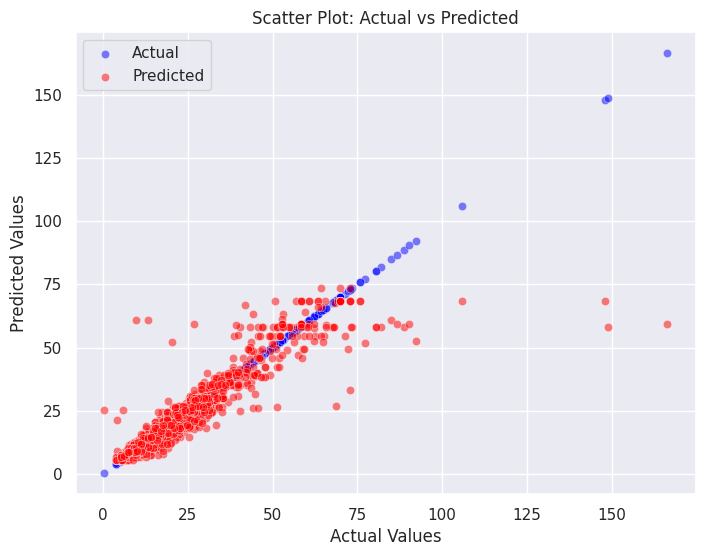

In [60]:
#Buat Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='actual', y='actual', data=prediction, color='blue', label='Actual', alpha=0.5)
sns.scatterplot(x='actual', y='pred', data=prediction, color='red', label='Predicted', alpha=0.5)
plt.title('Scatter Plot: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

Kelebihan model :
- Nilai rata-rata prediksi mendekati nilai aktual.
- Nilai Q1, Q2, Q3 prediction mendekati aktualnya.
- Miliki pola linear yang kuat. Sebagian besar titik data pred berada di sekitar titik data actual yang linear. Dapat diindikasikan model Random Forest berhasil menangkap pola utama dalam data atau model sudah dikatakan bekerja dengan baik untuk memprediksi sebagian besar data.  


Kekurangan model :  
- Nilai Minimum prediksi jauh lebih tinggi daripada nilai minimum aktual
- Terdapat beberapa outlier diluar pola linear, terutama pada nilai yang tinggi. Dapat diindikasikan model kesulitan memprediksi nilai ekstrem.   

Improvement :  
- Perlu perbaikan untuk meningkatkan nilai yang mendekati nilai minimum dan nilai maksimum.
- Perlu analisis outlier lebih lanjut untuk mengetahui penyebab outlier terutama saat nilainya ekstrem.



## IX. Model Saving

In [61]:
# Save model
with open('model.pkl', 'wb') as p:
    pickle.dump(best_model_rf, p)

## X. Model Inference

Model inference berada pada file P1M2_Reido_Vidaya_inf.ipynb

## XI. Pengambilan Kesimpulan

>Berdasarkan EDA Metode pembayaran yang sering digunakan adalah credit card dibandingkan cash dan jumlah penumpang 1 merupakan yang paling sering per tripnya.

> Berdasarkan analisis dari hasil modeling didapatkan model boosting tidak lebih baik daripada model lainnya dikarenakan boosting model memiliki nilai MAE dan r2 yang buruk.

> Berdasarkan hasil analisis bahwa hyperparameter tuning berpengaruh pada model kali ini didapatkan selisih nilai MAE menjadi lebih kecil dan ada peningkatan pada metrics r2nya

> Berdasarkan hasil analisis Model Random Forest merupakan model yang cocok digunakan untuk analisis Taxi price ini dikarenakan model tersebut yang memiliki selisih nilai MAE yang kecil dan r2 yang tinggi serta plot pada model tersebut menandakan sebagian besar nilai dapat terprediksi.


## Conceptual Problem

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !

>Bagging merupakan singkatan dari Bootstrap Aggregating dikarenakan menggabungkan bootstrapping dan aggregation untuk membentuk satu model ensemble

>Pada bagging, beberapa model dilatih secara independen pada subset data yang berbeda, kemudian prediksi dari setiap model digabungkan, untuk regresi biasanya menggunakan mean dan untuk klasifikasi menggunakan modus.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !

- Random Forest merupakan algoritma bagging dan adaboost merupakan algoritma boosting
- Random Forest menggunakan decision tree yang lebih kompleks dibandingkan adaboost
- Random Forest bekerja dengan cara menggabungkan model menggunakan mean untuk regresi atau modus untuk klasifikasi sedangkan adaboost bekerja dengan cara menggabungkan model dengan memberikan bobot pada model yang lebih baik dan melakukan koreksi dari model sebelumnya

3. Jelaskan apa yang dimaksud dengan Cross Validation

> Cross Validation adalh teknik untuk mempredict kinerja model pada data yang belum pernah dilihat sebelumnya. Cara kerjanya denganmengevaluasui beberapa model pada berbagai subset dari dataset.